In [1]:
import torch
import sys
import os.path as osp
import os
import sys
import numpy as np
from src.dataset.dataset import SimpleIterDataset, EventDataset, EventDatasetCollection
from src.utils.utils import to_filelist
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rc('font', size=13)
from src.plotting.plot_event import plot_event_comparison
from src.dataset.functions_data import concat_events
from src.utils.paths import get_path
from dotenv import load_dotenv
load_dotenv()

True

In [2]:

def remove_from_list(lst):
    out = []
    for item in lst:
        if item in ["hgcal", "data.txt", "test_file.root"]:
            continue
        out.append(item)
    return out

#path = "/eos/user/g/gkrzmanc/jetclustering/data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.7_alpha-peak"
def get_iter(path_to_ds):
    return iter(EventDatasetCollection(path_to_ds, args=None))

inputs = {
    "r_inv.=0.3, m_Z'=900 GeV": ["Delphes_020425_test_PU_PFfix_part0/SVJ_mZprime-900_mDark-20_rinv-0.3_alpha-peak"],
    "QCD": ["QCD_test_part0/qcd_test"]}


In [3]:
datasets = {
    key: get_iter([get_path(x, "preprocessed_data") for x in value]) for key, value in inputs.items()
}

Getting query for path Delphes_020425_test_PU_PFfix_part0/SVJ_mZprime-900_mDark-20_rinv-0.3_alpha-peak  | Preproc. data root= /work/gkrzmanc/jetclustering/preprocessed_data
File: final_gen_particles.pkl
File: final_parton_level_particles.pkl
File: pfcands.pkl
File: matrix_element_gen_particles.pkl
get_pfcands_key
Getting query for path QCD_test_part0/qcd_test  | Preproc. data root= /work/gkrzmanc/jetclustering/preprocessed_data
File: final_gen_particles.pkl
File: matrix_element_gen_particles.pkl
File: pfcands.pkl
File: final_parton_level_particles.pkl
get_pfcands_key


In [8]:
e.final_parton_level_particles.pid

NameError: name 'e' is not defined

In [4]:
e = next(datasets["QCD"])
# print

In [6]:
for i in range(len(e.pfcands)):
    # print pt,eta,phi,mass,charge
    print(e.pfcands.pt[i].item(), e.pfcands.eta[i].item(), e.pfcands.phi[i].item(), e.pfcands.mass[i].item(), e.pfcands.charge[i].item())

1.285908579826355 -2.2064461708068848 2.6301612854003906 0.9382699728012085 1.0
0.7487459778785706 -2.094208240509033 -0.05120047181844711 0.4936800003051758 -1.0
0.5246888995170593 -2.007927417755127 2.989550828933716 0.4936800003051758 -1.0
2.7525248527526855 -1.9870414733886719 -0.4528072476387024 0.13956999778747559 1.0
0.7956375479698181 -2.04066801071167 2.194350004196167 0.13956999778747559 -1.0
0.9809597134590149 -1.8432270288467407 -2.1718909740448 0.13956999778747559 1.0
0.6347672343254089 -1.8870458602905273 -2.357295513153076 0.13956999778747559 -1.0
0.5286186337471008 -1.8677940368652344 -1.5477248430252075 0.13956999778747559 -1.0
11.700090408325195 -1.7546323537826538 -0.2974643111228943 0.13956999778747559 1.0
4.672840118408203 -1.7406619787216187 -0.5989688038825989 0.13956999778747559 -1.0
0.9087695479393005 -1.68337881565094 -2.4570295810699463 0.13956999778747559 -1.0
3.460341215133667 -1.703657627105713 -0.5562939047813416 0.13956999778747559 1.0
1.8114593029022217

In [6]:
pid_masses = {}
for i in range(100):
    e = next(datasets["CMS FullSim"])
    for i in range(len(e.pfcands)):
        pid = e.pfcands.pid[i].item()
        if pid not in pid_masses:
            pid_masses[pid] = []
        pid_masses[pid].append(e.pfcands.mass[i].item())

In [ ]:
e = next(datasets["CMS FullSim"])

In [ ]:
pid_masses[211]

In [4]:
from tqdm import tqdm
ch_pids = torch.tensor([211, -211])
nh_pids = torch.tensor([130, 2112.0])
def get_stats(ds):
    LE_pfcands_PID= []
    result = {
        "n_pfcands": [],
        "pfcands_pt": [],
        "pfcands_eta": [],
        "pfcands_phi": [],
        "pfcands_pid": [],
        "pfcands_mass": [],
        "n_genp": [],
        "n_parton_level": [],
        "genp_pt": [],
        "parton_level_pt": [],
        "pt_ch": [], # low-pt CH
        "pt_nh": [], # low-pt NH
        "pt_gamma": [],
        "E_vis": [],
        "n_ch": [],
        "n_nh": [],
        "n_gamma": []
       # "n_dq": []
    }
    for _ in tqdm(range(10000)):
        event = next(ds)
        result["n_pfcands"].append(len(event.pfcands))
        result["pfcands_pt"] += torch.log10(event.pfcands.pt).tolist()
        result["pfcands_eta"] += event.pfcands.eta.tolist()
        result["pfcands_phi"] += event.pfcands.phi.tolist()
        result["pfcands_pid"] += event.pfcands.pid.tolist()
        result["pfcands_mass"] += event.pfcands.mass.tolist()
        result["n_genp"].append(len(event.final_gen_particles))
        result["n_parton_level"].append(len(event.final_parton_level_particles))
        result["genp_pt"] += torch.log10(event.final_gen_particles.pt).tolist()
        result["parton_level_pt"] += torch.log10(event.final_parton_level_particles.pt).tolist()
#        result["pt_ch"] += event.pfcands.pt[event.pfcands.pid.isin(ch_pids)].tolist()
        #result["n_dq"].append(len(event.matrix_element_gen_particles))
        result["pt_ch"] += torch.log10(event.pfcands.pt[torch.isin(event.pfcands.pid, ch_pids)]).tolist()
        result["pt_nh"] += torch.log10(event.pfcands.pt[torch.isin(event.pfcands.pid, nh_pids)]).tolist()
        result["pt_gamma"] += torch.log10(event.pfcands.pt[event.pfcands.pid == 22]).tolist()
        result["E_vis"].append(torch.sum(event.pfcands.E).item())
        result["n_ch"].append(torch.isin(event.pfcands.pid, ch_pids).sum().item())
        result["n_nh"].append(torch.isin(event.pfcands.pid, nh_pids).sum().item())
        result["n_gamma"].append((event.pfcands.pid == 22).sum().item())
    return result, LE_pfcands_PID

In [5]:
results = {
    key: get_stats(value)[0] for key, value in datasets.items()
}

#results_PID = {
#    key: get_stats(value)[1] for key, value in datasets.items()
#}

100%|██████████| 10000/10000 [00:25<00:00, 388.36it/s]


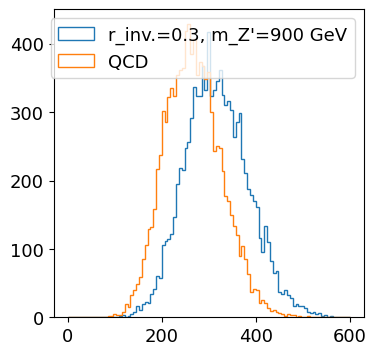

In [9]:
fig, ax = plt.subplots(figsize=(4,4))
for key in results:
    ax.hist(results[key]["n_pfcands"], bins=np.linspace(0, 600, 100), histtype="step", label=key, density=0)

ax.legend()
fig.show()

In [35]:
import pandas as pd
for key in results:
    print("#######", key, "#######")
    pids = results[key]["pfcands_pid"]
    print(pd.Series(pids).value_counts(normalize=True))
    print("dq", pd.Series(results[key]["n_dq"]).value_counts())

####### Delphes #######
211.0     0.591530
22.0      0.257798
2112.0    0.150672
Name: proportion, dtype: float64


KeyError: 'n_dq'

KeyboardInterrupt: 

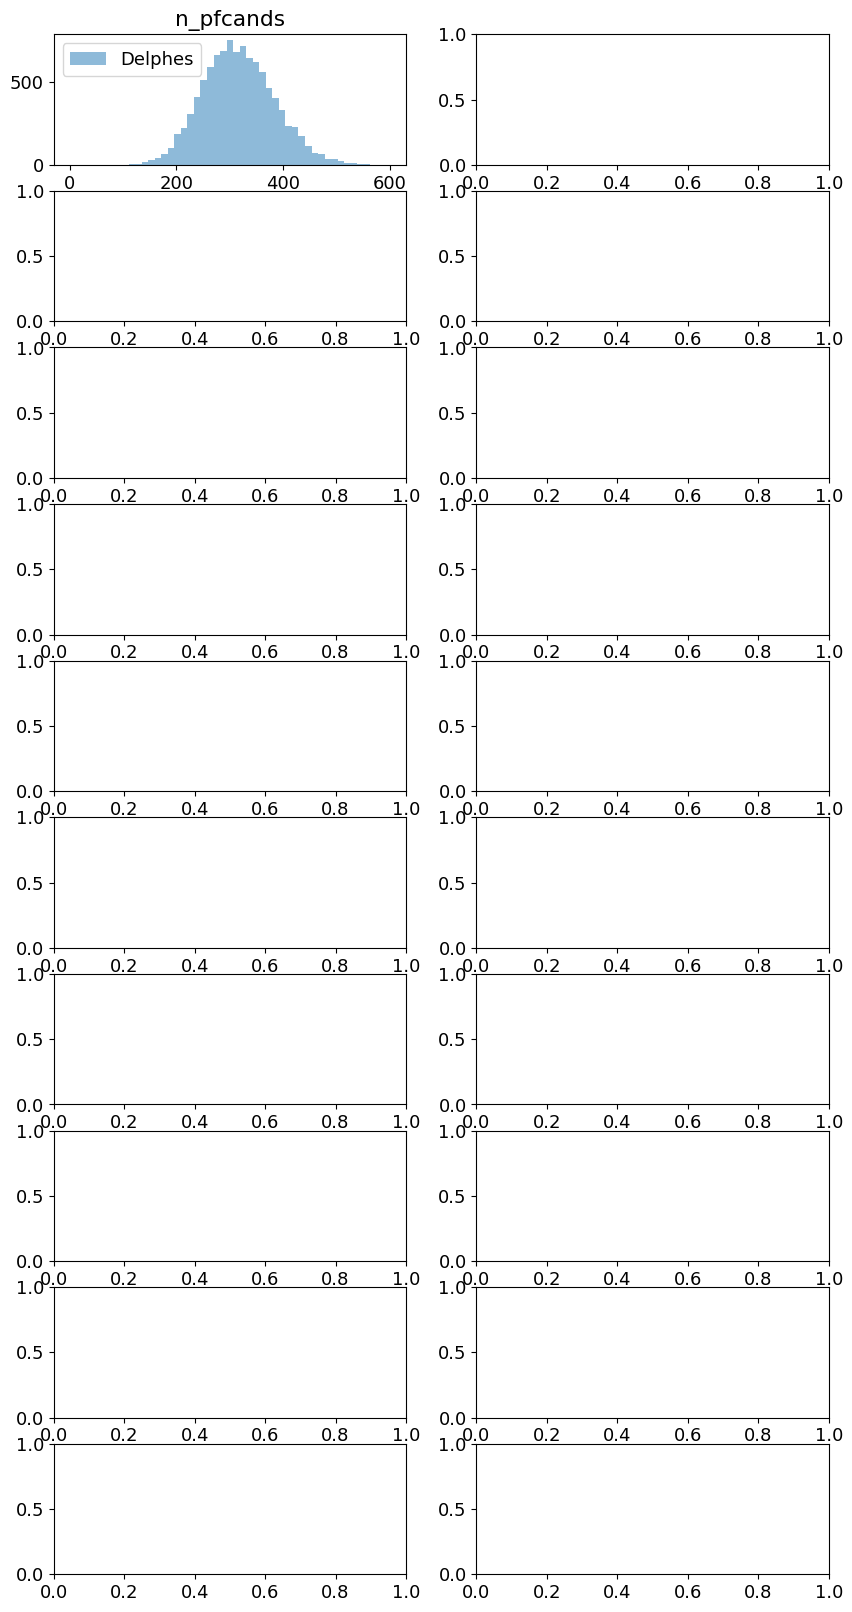

In [12]:
bins = {
    "n_pfcands": np.linspace(0, 600, 50),
    "pfcands_pt": np.linspace(-0.6, 2, 200),
    "pfcands_eta": np.linspace(-2.4, 2.4, 200),
    "pfcands_phi": np.linspace(-3.14, 3.14, 200),
    "pfcands_mass": np.linspace(0, 2, 100),
    "n_genp": np.linspace(0,600,50),
    "n_parton_level": np.linspace(0,600,50),
    "genp_pt": np.linspace(-1, 3, 200),
    "parton_level_pt": np.linspace(-1, 3, 200),
    "pt_ch": np.linspace(-1, 3, 200),
    "pt_nh": np.linspace(-1, 3, 200),
    "pt_gamma": np.linspace(-1, 3, 200),
    "E_vis": np.linspace(500, 10000, 200),
    "n_gamma": np.linspace(0, 1200, 200),
    "n_ch": np.linspace(0, 1200, 200),
    "n_nh": np.linspace(0, 1200, 200),
    #"n_dq": np.linspace(0, 3, 3)
}
fig, ax = plt.subplots(10, 2, figsize=(10, 20))
for key in results:
    for i, (k, v) in enumerate(results[key].items()):
        if k == "pfcands_pid":
            continue
        ax[i // 2, i % 2].hist(v, bins=bins[k], alpha=0.5, label=key, density="pt" in k)
        ax[i // 2, i % 2].set_title(k)
        if k == "pfcands_pt" or "mass" in k:# or "_pt" in k:
            if not k == "pfcands_pt":
                ax[i//2, i%2].set_yscale("log")
            #ax[i//2, i%2].set_xscale("log")
        ax[i // 2, i % 2].legend()

fig.show()


In [17]:
min(results["Delphes"]["pfcands_pt"])

-0.3010289602264827

In [18]:
min(results["CMS FullSim"]["pfcands_pt"])


-0.22177806941733907

In [19]:
min(results["CMS FullSim"]["pfcands_eta"])


-2.3984375

In [27]:
np.array(results["Delphes"]["n_nh"])


array([0, 0, 0, ..., 0, 0, 0])

In [21]:
t = torch.tensor(results["CMS FullSim"]["pfcands_pt"])

In [22]:
t[t<0.222]

tensor([ 0.2212,  0.2194,  0.2191,  ..., -0.2158, -0.2172, -0.2200])

In [23]:
import pandas as pd
for key in results_PID:
    print(key, "number of PFCands in sample:", len(results_PID[key]))
    print(pd.value_counts(pd.Series(results_PID[key]), normalize=False))


Delphes number of PFCands in sample: 426711
211.0     306595
22.0       95529
2112.0     24587
Name: count, dtype: int64
CMS FullSim number of PFCands in sample: 149427
 22.0     75853
 130.0    28642
 211.0    22569
-211.0    22363
Name: count, dtype: int64


/tmp/ipykernel_61141/3118960101.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(pd.Series(results_PID[key]), normalize=False))


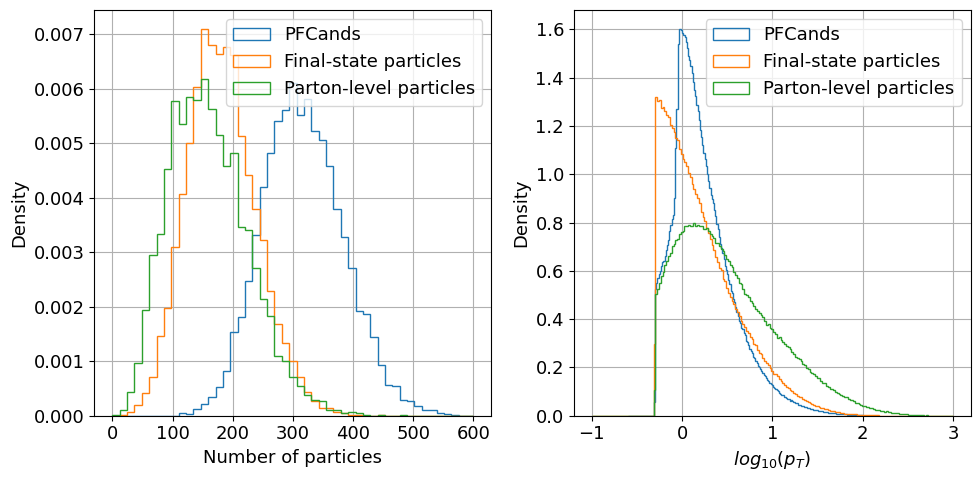

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(results["Delphes"]["n_pfcands"], bins=bins["n_pfcands"], histtype="step", density=True, label="PFCands")
ax[1].hist(results["Delphes"]["pfcands_pt"], bins=bins["pfcands_pt"], histtype="step", density=True, label="PFCands")
ax[1].hist(results["Delphes"]["genp_pt"], bins=bins["genp_pt"], histtype="step", density=True, label="Final-state particles")
ax[0].hist(results["Delphes"]["n_genp"], bins=bins["n_genp"], histtype="step", density=True, label="Final-state particles")
ax[0].hist(results["Delphes"]["n_parton_level"], bins=bins["n_parton_level"], histtype="step", density=True, label="Parton-level particles")
ax[1].hist(results["Delphes"]["parton_level_pt"], bins=bins["parton_level_pt"], histtype="step", density=True, label="Parton-level particles")

ax[0].set_ylabel("Density")
ax[0].set_xlabel("Number of particles")
ax[1].set_ylabel("Density")
ax[1].set_xlabel(r"$log_{10}(p_T)$")
ax[0].grid()
ax[0].legend()
ax[1].grid()
ax[1].legend()
fig.tight_layout()
fig.show()
fig.savefig("/work/gkrzmanc/jetclustering/plot_dataset_stats_900_03.pdf")

In [9]:
coords = [[-1.5495,  1.5181, -4.9033],
        [ 1.8002, -0.5530, -3.8560],
        [-1.9474,  0.6230, -4.3363],
        [ 1.7321, -0.6857, -3.8155],
        [-1.2961,  1.6802, -4.8287],
        [-1.2839, -2.1370, -4.4393],
        [-1.4424, -1.7286, -4.2799],
        [ 0.1110, -2.0428, -4.0486],
        [ 1.7312, -0.6954, -3.8144],
        [ 1.7297, -0.6824, -3.8322],
        [-1.8395, -1.7283, -3.9620],
        [ 1.7296, -0.6818, -3.8273],
        [ 1.8919, -0.8495, -3.5727],
        [ 2.1612,  1.0300, -2.7974],
        [-0.8509,  2.2663, -2.4021],
        [ 2.4569,  0.3862, -1.1353],
        [-2.3553,  1.1776, -1.1737],
        [ 1.9910,  1.1444, -1.0023],
        [-2.5883,  0.0416, -0.7842],
        [-2.5706, -0.4352, -0.3717],
        [-1.0482,  1.9849,  2.2524],
        [ 0.2583, -3.0923,  1.6670],
        [ 0.2733, -3.0734,  1.6618],
        [ 0.2736, -3.0727,  1.6619],
        [ 0.2721, -3.0689,  1.6643],
        [ 0.2788, -3.1115,  1.6720],
        [ 0.2725, -3.0669,  1.6684],
        [ 0.2710, -3.0689,  1.6641],
        [ 0.2585, -3.0979,  1.6599],
        [-1.0291,  2.0454,  2.2981],
        [-1.0465,  1.9903,  2.2726],
        [-1.0302,  1.9728,  2.2429],
        [-1.0280,  1.9718,  2.2419],
        [-1.0539,  1.9851,  2.2746],
        [-2.5836, -0.1239,  2.0100],
        [ 0.6796,  2.2723,  2.5656],
        [-0.1359,  2.5075,  2.0266],
        [-1.0477,  1.9909,  2.2711],
        [-1.0507,  1.9939,  2.2730],
        [-1.0606,  2.0036,  2.2905],
        [-1.0532,  1.9953,  2.2756],
        [-1.0605,  1.9991,  2.2831],
        [-1.5282, -1.5603,  3.4762],
        [-2.2670, -0.2648,  2.6845],
        [-1.9903, -0.6650,  3.4736],
        [-1.4865, -1.2766,  3.9683],
        [ 1.7136, -0.7725,  4.5989],
        [ 1.8753,  1.3465,  4.3027],
        [-0.5179,  1.5121,  4.1774],
        [-0.8766,  0.8558,  4.4702],
        [-0.0182, -1.2837,  4.9791],
        [-0.1444,  1.1217,  4.6578],
        [ 1.7559, -0.6154, -3.8510],
        [-1.2387, -1.9353, -4.9707],
        [ 1.7268,  1.1658, -4.3823],
        [-1.4515,  1.6441, -4.8593],
        [-1.3179,  1.6815, -4.7743],
        [-0.1045, -2.3308, -4.3743],
        [-1.8832, -1.3721, -4.3317],
        [ 1.7287, -0.6889, -3.8307],
        [-0.6607,  2.0334, -4.5526],
        [ 1.7270, -0.6859, -3.8331],
        [ 1.7289, -0.6878, -3.8302],
        [ 1.7307, -0.6913, -3.8281],
        [ 1.7300, -0.6917, -3.8338],
        [ 1.7237, -0.6834, -3.8404],
        [ 0.9324,  2.1103, -3.8345],
        [ 0.1314, -2.6416, -3.7561],
        [ 0.4108,  2.4644, -3.4821],
        [ 1.8581,  1.6913, -2.9619],
        [-0.6988, -2.8416, -3.4301],
        [-2.4096,  1.0791, -3.0608],
        [-1.9346, -2.3986, -3.2612],
        [-2.8202, -0.3674, -2.5191],
        [ 1.5948, -2.3387, -2.6920],
        [-2.3447,  1.4450, -2.6945],
        [ 1.8883,  1.8531, -2.4968],
        [-2.7066,  0.8713, -2.0058],
        [ 1.2271, -2.0250, -1.7775],
        [-0.4909,  2.5491, -1.7718],
        [-2.4650,  1.2539, -1.6431],
        [-2.4215,  1.2844, -1.5542],
        [-2.9195, -0.0815, -1.5910],
        [-0.2205,  2.4693, -1.3814],
        [ 0.1663,  2.6569, -1.5103],
        [ 2.1484, -1.5973, -1.3556],
        [-2.2260,  1.4108, -0.9103],
        [ 1.9613, -1.7548, -1.1233],
        [-2.4416,  1.0491, -0.3177],
        [-0.2563,  2.7018, -0.8662],
        [-2.7791, -0.5757, -0.5431],
        [ 0.4024,  2.6131, -0.4431],
        [ 2.5178,  0.8502,  0.4847],
        [-2.6602,  0.8035,  0.3658],
        [ 0.2553, -3.0933,  1.7118],
        [-2.5910, -1.0201,  0.2433],
        [-2.7835, -0.8216,  0.2306],
        [ 2.5159, -0.1739,  0.9913],
        [ 0.2363, -3.0927,  1.6966],
        [-2.7367, -0.6971,  0.3999],
        [-2.7609, -0.3865,  0.7086],
        [-1.6522,  1.8659,  1.7182],
        [ 0.2578, -3.0862,  1.6667],
        [-0.2298,  2.6499,  1.5963],
        [ 0.2508, -3.0918,  1.6665],
        [ 0.2482, -3.0926,  1.6696],
        [ 0.2737, -3.0784,  1.6605],
        [ 0.2481, -3.0917,  1.6644],
        [ 0.2647, -3.0850,  1.6596],
        [ 0.2623, -3.0884,  1.6588],
        [-1.4646,  1.8452,  2.0915],
        [-2.2643, -1.6206,  1.0842],
        [ 0.2301, -3.1009,  1.6605],
        [-1.4628,  1.8018,  2.2425],
        [ 0.2339, -3.0795,  1.6793],
        [-1.0385,  1.9833,  2.2603],
        [-1.0577,  1.9904,  2.2839],
        [-1.0558,  1.9922,  2.2834],
        [-1.0527,  1.9960,  2.2797],
        [-1.0536,  1.9928,  2.2801],
        [-1.0539,  1.9982,  2.2807],
        [-1.0590,  1.9991,  2.2892],
        [-1.0658,  2.0011,  2.3000],
        [-1.2474,  1.8863,  2.3004],
        [ 2.1478,  1.7096,  2.9009],
        [-1.0622,  1.9916,  2.2844],
        [-2.3035, -1.0750,  2.2711],
        [-1.0710,  1.9968,  2.3003],
        [-2.6559, -0.5099,  2.6154],
        [-2.5435, -0.7722,  2.6196],
        [-1.7327, -1.5407,  2.8306],
        [ 1.4247,  2.1963,  3.1533],
        [-2.4239, -0.7195,  2.7774],
        [ 1.0783, -1.5793,  3.5572],
        [-1.0719,  2.0107,  2.3254],
        [-1.5413, -1.5747,  3.8089],
        [-1.9877,  0.3660,  3.7720],
        [-0.8537, -1.5105,  4.3160],
        [ 1.2687, -1.1840,  4.4178],
        [-1.1016,  1.9143,  2.5185],
        [-0.5844,  1.9916,  3.0937],
        [ 0.4118, -1.4831,  4.8097],
        [-1.9231, -0.8451,  4.5775],
        [ 1.6286,  1.5225,  4.2854],
        [ 0.6973, -1.3760,  4.7879],
        [-0.7651,  1.6440,  3.5630],
        [-1.6317, -0.8411,  4.5377],
        [-1.3141,  0.5300,  4.4915],
        [-0.2546, -1.3260,  4.7748],
        [ 0.8105, -1.3046,  4.9323],
        [-1.2935, -1.0732,  4.7983],
        [ 1.1187,  1.4635,  4.6111],
        [ 0.1263, -1.4405,  5.2035],
        [-0.7197,  0.8044,  4.7162],
        [-1.2921,  0.2434,  4.8551],
        [-1.4319,  1.6379, -4.9875],
        [-1.3789, -1.7148, -4.7961],
        [-1.0506, -1.9610, -4.9114],
        [ 1.8139, -0.3751, -3.9478],
        [-0.4422,  2.0030, -4.6756],
        [-1.5153,  1.4905, -4.8983],
        [-0.7448, -2.0965, -4.8363],
        [ 1.7369, -0.6929, -3.8165],
        [ 1.1666,  1.8592, -4.3868],
        [-1.5347,  1.4869, -4.8752],
        [ 1.7298, -0.6822, -3.8200],
        [ 1.7221, -0.6895, -3.8375],
        [ 0.5449,  2.1305, -4.2536],
        [ 1.8106, -0.5354, -3.8379],
        [ 0.4226,  2.2470, -4.3040],
        [ 2.0053, -0.0148, -3.8170],
        [ 1.7022, -0.7035, -3.8582],
        [ 1.9207, -0.2926, -3.7746],
        [-2.5486,  0.5570, -4.0015],
        [ 0.4743, -2.4599, -3.9817],
        [ 1.7211, -0.6852, -3.8501],
        [-2.7976,  0.2078, -3.4566],
        [ 1.9234,  1.6622, -2.9035],
        [ 2.6970,  0.6452, -1.9762],
        [ 0.8624,  2.4908, -1.7694],
        [-2.7716,  0.7279, -1.8379],
        [-2.5015,  1.3891,  0.7576],
        [-2.5478,  1.2249,  1.2333],
        [ 0.2852, -3.1159,  1.6838],
        [ 0.2703, -3.0723,  1.6628],
        [ 0.2747, -3.0758,  1.6664],
        [ 0.2716, -3.0663,  1.6699],
        [-1.0502,  1.9967,  2.2694],
        [-1.0356,  1.9797,  2.2523],
        [ 2.3012,  1.7356,  2.6705],
        [-1.0417,  1.9858,  2.2603],
        [-2.5048,  0.7891,  2.2492],
        [-1.0761,  1.9841,  2.2889],
        [ 0.2233, -2.7180,  1.8989],
        [ 2.0025,  1.5902,  3.8203],
        [ 2.3503, -0.5705,  4.4868],
        [-1.9414, -0.4823,  4.0726],
        [ 0.5874, -1.5055,  5.0040],
        [ 2.0987,  1.1740,  4.4301],
        [-1.5761, -1.0223,  4.9043],
        [ 0.7406, -1.4267,  5.0236],
        [ 1.1782, -1.2781,  4.8671],
        [ 2.3957,  0.4659,  4.7731],
        [-0.7265,  1.0960,  4.3860],
        [-1.6559,  0.0731,  4.6102],
        [-1.4022, -0.9981,  4.6817],
        [ 0.4934, -1.4326,  5.1184],
        [ 0.8276, -1.3685,  5.1070],
        [-1.5080,  0.0846,  4.9621],
        [-1.5497, -0.0830,  4.8425],
        [ 1.5397, -0.8816,  4.9830],
        [ 2.0744,  0.9103,  4.7717]]
coords = torch.tensor(coords)

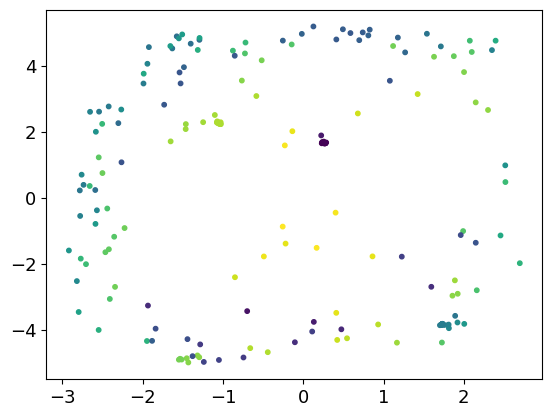

In [12]:
fig, ax = plt.subplots()
ax.scatter(coords[:, 0], coords[:, 2], s=10, c=coords[:, 1], cmap="viridis")